# Agents with LlamaIndex I - Data Agents

Sources [1](https://docs.llamaindex.ai/en/stable/module_guides/deploying/agents/), [2](https://docs.llamaindex.ai/en/stable/understanding/putting_it_all_together/agents/), [3](https://docs.llamaindex.ai/en/stable/examples/agent/custom_agent/), [4](https://docs.llamaindex.ai/en/stable/examples/agent/openai_agent/), [5](https://docs.llamaindex.ai/en/stable/module_guides/deploying/agents/agent_runner/), [6](https://medium.com/llamaindex-blog/data-agents-eed797d7972f), [7](https://akash-mathur.medium.com/advanced-rag-query-augmentation-for-next-level-search-using-llamaindex-d362fed7ecc3)    

Data Agents, empowered by LLMs are knowledge workers within LlamaIndex, designed to interact with various types of data. These agents can handle both unstructured and structured data, significantly enhancing the capabilities beyond traditional query/chat engines.

![](https://miro.medium.com/v2/resize:fit:1000/format:webp/1*cWwW01Ez_JIS2hcMJwcV8Q.png)  

Here's a high level overview about it:

+ Functionality: Data Agents can autonomously conduct searches and retrieve information across unstructured, semi-structured, and structured data. They are not limited to just reading data; they can also write, modify, and store information by integrating with external service APIs.

+ Dynamic Interaction: Unlike static query/chat engines, Data Agents can dynamically interact with data sources. They can ingest new data and adapt based on the information they process, offering a more flexible and responsive approach to data management.

Building a data agent requires the following core components:

1. Reasoning loop
2. Tool abstractions

![](https://miro.medium.com/v2/resize:fit:1000/format:webp/1*WPOS7tiljXCrd3IkJy84CQ.png)  

A data agent is initialized with set of APIs, or Tools, to interact with; these APIs can be called by the agent to return information or modify state. Given an input task, the data agent uses a reasoning loop to decide which tools to use, in which sequence, and the parameters to call each tool.

---

1. Reasoning Loop - The reasoning loop depends on the type of agent, as following:
    + ReAct agent (works across any chat/text completion endpoint). - [Video](https://www.youtube.com/watch?v=pRUc6JPw6CY), [Code](https://colab.research.google.com/drive/1XYNaGvEdyKVbs4g_Maffyq08DUArcW8H?usp=sharing)  
    + Function Calling Agents (integrates with any function calling LLM) - [Video](https://www.youtube.com/watch?v=6INvyrC4WrA), [Code](https://colab.research.google.com/drive/1GyPRMiwxS7rKxKpRt4r-ckYfmAw2GxdQ?usp=sharing)  
    + "Advanced Agents": 
        + Retrieval Augmented Function Calling Agent - [Video](https://www.youtube.com/watch?v=K7h17Jjtbzg), [Code](https://colab.research.google.com/drive/1R41zIhVybCNqg67eVEPuyLeMp_HYwTlA?usp=sharing)  
        + Controlling Agent Reasoning Loop - [Video](https://www.youtube.com/watch?v=gFRbkRtLGZQ), [Code](https://colab.research.google.com/drive/1c5ORIlqs3YMWosDSMgs6_ZHb5eiANS1c?usp=sharing)  
        + StepWise Controllable Agent - [Video](https://www.youtube.com/watch?v=JGkSxdPFgyQ), [Code](https://colab.research.google.com/drive/1x-CR_KA7LzhPhLdITycojAJVamEaKsaO?usp=sharing)  
        + [LLMCompiler](https://llamahub.ai/l/llama-packs/llama-index-packs-agents-llm-compiler?from=)  
        + [Chain-of-Abstraction](https://llamahub.ai/l/llama-packs/llama-index-packs-agents-coa?from=)  
        + [Language Agent Tree Search](https://llamahub.ai/l/llama-packs/llama-index-packs-agents-lats?from=)  
        + and more...

---

2. Tool Abstractions - At their core, tool abstractions allow for a structured way to define how Data Agents can interact with data or services. Unlike typical APIs designed for human users, these tools are optimized for automated interactions, enabling agents to execute tasks with precision and efficiency.

Types of Tools:

+ FunctionTool - A function tool allows users to easily convert any user-defined function into a Tool. It can also auto-infer the function schema.
+ QueryEngineTool - A tool that wraps an existing query engine. 

[LlamaHub Tools](https://llamahub.ai/?tab=tools)  
    
--- 

## Installing Packages

In [1]:
!pip install -q openai
!pip install -q llama-index
!pip install -q llama-index-experimental
!pip install -q pypdf
!pip install -q docx2txt

## Importing Packages

In [4]:
import os
import openai

#os.environ["OPENAI_API_KEY"] = "<the key>"
openai.api_key = os.environ["OPENAI_API_KEY"]

import sys
import shutil
import glob
import logging
from pathlib import Path
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

import pandas as pd

## Llamaindex LLMs
from llama_index.llms.openai import OpenAI

## Llamaindex readers
from llama_index.core import SimpleDirectoryReader

## LlamaIndex Index Types
from llama_index.core import ListIndex
from llama_index.core import VectorStoreIndex
from llama_index.core import TreeIndex
from llama_index.core import KeywordTableIndex
from llama_index.core import SimpleKeywordTableIndex
from llama_index.core import DocumentSummaryIndex
from llama_index.core import SummaryIndex
from llama_index.core import KnowledgeGraphIndex
from llama_index.experimental.query_engine import PandasQueryEngine

## LlamaIndex Context Managers
from llama_index.core import StorageContext
from llama_index.core import load_index_from_storage
from llama_index.core.response_synthesizers import get_response_synthesizer
from llama_index.core.response_synthesizers import ResponseMode
from llama_index.core.schema import Node
from llama_index.core import Settings

## LlamaIndex Templates
from llama_index.core.prompts import PromptTemplate
from llama_index.core.prompts import ChatPromptTemplate
from llama_index.core.base.llms.types import ChatMessage, MessageRole

## LlamaIndex Agents
from llama_index.core.tools import FunctionTool
from llama_index.core.agent import ReActAgent

## LlamaIndex Callbacks
from llama_index.core.callbacks import CallbackManager
from llama_index.core.callbacks import LlamaDebugHandler

import nest_asyncio
nest_asyncio.apply()

In [2]:
import logging

#logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
#logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

# 1st. Example - [Router Engine](https://docs.llamaindex.ai/en/stable/module_guides/querying/router/)  

![](https://miro.medium.com/v2/resize:fit:1000/1*pwwxzWABv4cJDWonJ7LImg.png)

A Router Query Engine serves as a powerful decision-making module that plays a crucial role in selecting the most appropriate choices based on user queries and metadata-defined options. These routers are versatile modules that can operate independently as “selector modules” or can be utilized as query engines or retrievers on top of other query engines or retrievers.

Routers excel in various use cases, including selecting the appropriate data source from a diverse range of options and deciding whether to perform summarization or semantic search based on the user query. They can also handle more complex tasks like trying out multiple choices simultaneously and combining the results using multi-routing capabilities.

We also define a “selector”. Users can easily employ routers as query engines or retrievers, with the router taking on the responsibility of selecting query engines or retrievers to route user queries effectively.

Steps:  
+ The source document is indexed with sentence splitting with a fixed window size
+ Create summary and vector indexes
+ From indices, we obtain query engines, respectively
+ Bind all search engines to the agents as tools
+ The agent will choose a tool based on the overall prompts
+ Query on the agent.

#### Defining Models

In [12]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

model="gpt-3.5-turbo"
#model="gpt-4"
#model="gpt-4-turbo"

Settings.embed_model = OpenAIEmbedding(model="text-embedding-ada-002")
Settings.llm = OpenAI(temperature=0, 
                      model=model, 
                      #max_tokens=512
                      PRESENCE_PENALTY=-2,
                      TOP_P=1,
                     )

#### Defining Folders

In [13]:
DOCS_DIR = "../Data/"
PERSIST_DIR = "../Index/"

print(f"Current dir: {os.getcwd()}")

if not os.path.exists(DOCS_DIR):
  os.mkdir(DOCS_DIR)
docs = os.listdir(DOCS_DIR)
docs = [d for d in docs]
docs.sort()
print(f"Files in {DOCS_DIR}")
for doc in docs:
    print(doc)

Current dir: /home/renato/Documents/Repos/GenAI4Humanists/Notebooks
Files in ../Data/
1.pdf
WarrenCommissionReport.txt
axis_report.pdf
california_housing_train.csv
hdfc_report.pdf
hr.sqlite
icici_report.pdf
kafka_metamorphosis.txt
knowledge_card.pdf
loftq.pdf
longlora.pdf
lyft_2021.pdf
metagpt.pdf
metra.pdf
paul_graham_essay.txt
selfrag.pdf
swebench.pdf
uber_2021.pdf
values.pdf
vr_mcl.pdf
zipformer.pdf


## Load Data  
A single file

In [15]:
#### To download this paper, below is the needed code:
#!wget "https://openreview.net/pdf?id=VtmBAGCN7o" -O ../Data/metagpt.pdf

In [16]:
documents = SimpleDirectoryReader(input_files=[f"{DOCS_DIR}metagpt.pdf"]).load_data()

In [17]:
from llama_index.core.node_parser import SentenceSplitter

splitter = SentenceSplitter(chunk_size=1024)
nodes = splitter.get_nodes_from_documents(documents)

In [18]:
print(len(nodes))
nodes[0]

34


TextNode(id_='3822c646-b7a2-4465-b3c4-0bbb120f7b67', embedding=None, metadata={'page_label': '1', 'file_name': 'metagpt.pdf', 'file_path': '../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-30', 'last_modified_date': '2024-05-30'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='6a1efb0e-f576-40de-81fc-2aaa1f971a73', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '1', 'file_name': 'metagpt.pdf', 'file_path': '../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-30', 'last_modified_date': '2024-05-30'}, hash='beeb3dd9321a27647fb2e35eb523ffbf5347926c26b98176c6004bdc1ac9a164')}, text='Preprint\

## Define Summary Index and Vector Index over the Same Data

In [19]:
#from llama_index.core import SummaryIndex, VectorStoreIndex

summary_index = SummaryIndex(nodes)
vector_index = VectorStoreIndex(nodes)

## Define Query Engines Tools and Set Metadata for each Tool

In [20]:
summary_query_engine = summary_index.as_query_engine(response_mode="tree_summarize", use_async=True,)
vector_query_engine = vector_index.as_query_engine()

In [21]:
from llama_index.core.tools import QueryEngineTool

summary_tool = QueryEngineTool.from_defaults(
    query_engine=summary_query_engine,
    description=("Useful for summarization questions related to MetaGPT"),
)

vector_tool = QueryEngineTool.from_defaults(
    query_engine=vector_query_engine,
    description=("Useful for retrieving specific context from the MetaGPT paper."),
)

## Define Router Query Engine to use Tools

In [22]:
from llama_index.core.query_engine.router_query_engine import RouterQueryEngine
from llama_index.core.selectors import LLMSingleSelector

query_engine = RouterQueryEngine(
    selector=LLMSingleSelector.from_defaults(),
    query_engine_tools=[summary_tool, vector_tool,],
    verbose=True
)

## Testing

In [23]:
response = query_engine.query("What is the summary of the document?")
print(str(response))

Selecting query engine 0: Useful for summarization questions related to MetaGPT.
The document introduces MetaGPT, a meta-programming framework that utilizes Standardized Operating Procedures (SOPs) to enhance multi-agent systems based on Large Language Models (LLMs). It incorporates role specialization, workflow management, and efficient communication mechanisms to improve code generation quality. Through experiments, MetaGPT demonstrates state-of-the-art performance on various benchmarks in software development tasks. The document details the development process of a software application called "Drawing App" using MetaGPT, outlining the roles of different agents and discussing the use of Python libraries for GUI creation, color selection, and testing. It also covers performance comparisons with other models, the impact of instruction levels on software development, challenges addressed by MetaGPT, and limitations and ethical considerations related to the system.


In [24]:
print(len(response.source_nodes))

34


In [25]:
response = query_engine.query("How do agents share information with other agents?")
print(str(response))

Selecting query engine 1: This choice is more relevant as it focuses on retrieving specific context from the MetaGPT paper, which may provide insights on how agents share information with other agents..
Agents share information with other agents by utilizing a shared message pool. This shared message pool allows all agents to exchange messages directly. Agents publish their structured messages in the pool and can also access messages from other entities transparently. This system enables any agent to retrieve required information directly from the shared pool, eliminating the need to inquire about other agents and wait for their responses, thus enhancing communication efficiency.


In [26]:
print(len(response.source_nodes))

2


# 2nd. Example - [Sub Question Query Engine](https://docs.llamaindex.ai/en/stable/examples/query_engine/sub_question_query_engine/)  

[Source data](https://docs.llamaindex.ai/en/latest/examples/usecases/10k_sub_question/)

Normal query engines are designed to locate relevant information within vast datasets. They act as intermediaries between users’ questions and stored data. When a user poses a query, the engine carefully analyzes it, pinpoints relevant data, and presents a comprehensive response.  

While traditional query engines excel at straightforward questions, they often face challenges when confronted with multi-faceted questions spanning multiple documents. Simply merging documents and extracting top k elements frequently fails to capture the nuances required for truly informative responses.  

Decomposition Strategy: To address this complexity, Sub-Question Query Engines adopt a divide-and-conquer approach. They elegantly decompose complex queries into a series of sub-questions, each targeting specific aspects of the original inquiry.  

The implementation involves defining a Sub-Question Query Engine for each data source. Instead of treating all documents equally, the engine strategically addresses sub-questions specific to each data source. To generate the final response, a top-level Sub-Question Query Engine is then employed to synthesize the results from individual sub-questions.  

Given the initial complex question, we use LLM to generate sub-questions and execute sub-questions on selected data sources. It gathers all sub-responses and then synthesizes the final response.  

Sub-Question Query Engine focuses on the divide-and-conquer approach. It decomposes a complex query into a series of smaller, focused sub-questions. Each sub-question is sent to a dedicated Sub-Question Query Engine that retrieves relevant information from its specific data source. Hence, it ensures each sub-question gets the appropriate data source, leading to more precise results. It provides comprehensive answers by aggregating insights from various sub-questions to provide a holistic response.  

In [27]:
#from llama_index.core.tools import QueryEngineTool
from llama_index.core.tools import ToolMetadata
from llama_index.core.query_engine import SubQuestionQueryEngine

#### Load data

In [28]:
lyft_docs = SimpleDirectoryReader(input_files=[f"{DOCS_DIR}lyft_2021.pdf"]).load_data()
uber_docs = SimpleDirectoryReader(input_files=[f"{DOCS_DIR}uber_2021.pdf"]).load_data()

#### Build indices

In [29]:
lyft_index = VectorStoreIndex.from_documents(lyft_docs)
uber_index = VectorStoreIndex.from_documents(uber_docs)

#### Build query engines

In [30]:
lyft_engine = lyft_index.as_query_engine(similarity_top_k=3)
uber_engine = uber_index.as_query_engine(similarity_top_k=3)

In [31]:
query_engine_tools = [
    QueryEngineTool(
        query_engine=lyft_engine,
        metadata=ToolMetadata(
            name="lyft",
            description=(
                "Provides information about Lyft financials for year 2021"
            ),
        ),
    ),
    QueryEngineTool(
        query_engine=uber_engine,
        metadata=ToolMetadata(
            name="uber",
            description=(
                "Provides information about Uber financials for year 2021"
            ),
        ),
    ),
]

s_engine = SubQuestionQueryEngine.from_defaults(
    query_engine_tools=query_engine_tools
)

#### Run queries

In [32]:
response = s_engine.query(
    "Compare and contrast the customer segments and geographies that grew the"
    " fastest"
)

Generated 4 sub questions.
[lyft] Q: What were the customer segments that grew the fastest for Lyft in 2021?
[lyft] Q: What were the geographies that grew the fastest for Lyft in 2021?
[uber] Q: What were the customer segments that grew the fastest for Uber in 2021?
[uber] Q: What were the geographies that grew the fastest for Uber in 2021?
[uber] A: The customer segments that grew the fastest for Uber in 2021 were the membership programs, specifically Uber One, Uber Pass, Eats Pass, and Rides Pass.
[lyft] A: Riders who use Lyft to commute to and from work, explore their cities, spend more time at local businesses, and stay out longer knowing they can get a reliable ride home.
[uber] A: Chicago, Miami, New York City in the United States, Sao Paulo in Brazil, and London in the United Kingdom were the geographies that grew the fastest for Uber in 2021.
[lyft] A: The geographies that grew the fastest for Lyft in 2021 were those where vaccines were more widely distributed and communities f

In [33]:
print(response)

The customer segments that grew the fastest for Lyft in 2021 were riders who used the service for commuting, exploring cities, supporting local businesses, and ensuring a reliable ride home. On the other hand, the customer segments that experienced the fastest growth for Uber in 2021 were related to membership programs such as Uber One, Uber Pass, Eats Pass, and Rides Pass.

In terms of geographies, Lyft experienced the fastest growth in areas where vaccines were widely distributed and communities fully reopened, leading to a significant increase in Active Riders. In contrast, Uber saw the fastest growth in cities like Chicago, Miami, New York City, Sao Paulo, and London across different countries.


In [34]:
response = s_engine.query(
    "Compare revenue growth of Uber and Lyft from 2020 to 2021"
)

Generated 4 sub questions.
[uber] Q: What was the revenue of Uber in 2020?
[uber] Q: What was the revenue of Uber in 2021?
[lyft] Q: What was the revenue of Lyft in 2020?
[lyft] Q: What was the revenue of Lyft in 2021?
[uber] A: $11,139
[uber] A: The revenue of Uber in 2021 was $17,455 million.
[lyft] A: Lyft's revenue in 2020 was $2,364,681.
[lyft] A: The revenue of Lyft in 2021 was $3,208,323,000.


In [35]:
print(response)

The revenue growth of Uber from 2020 to 2021 was $6,316 million, while the revenue growth of Lyft during the same period was $843,642,000.


# 3nd. Example - [Tool Calling](https://docs.llamaindex.ai/en/stable/module_guides/deploying/agents/tools/)  


![](https://miro.medium.com/v2/resize:fit:720/1*WPOS7tiljXCrd3IkJy84CQ.png)

## Define Simple Tools

In [36]:
from llama_index.core.tools import FunctionTool

def add(x: int, y: int) -> int:
    """Adds two integers together."""
    return x + y

def subtract(x: int, y: int) -> int: 
    """Subtract the second number from the first number."""
    return (x - y)

def multiply(x: int, y: int) -> int: 
    """Multiply one number by the other number."""
    return (x * y)

def uppercase(x: str) -> str: 
    """Return the input string in uppercase."""
    return (x.upper())

add_tool = FunctionTool.from_defaults(fn=add)
subtract_tool = FunctionTool.from_defaults(fn=subtract)
multiply_tool = FunctionTool.from_defaults(fn=multiply)
uppercase_tool = FunctionTool.from_defaults(fn=uppercase)

In [37]:
#from llama_index.llms.openai import OpenAI
llm = OpenAI(model="gpt-3.5-turbo")

response = llm.predict_and_call(
    [add_tool, subtract_tool, multiply_tool, uppercase_tool], 
    "Tell me the output of 3 - 12 ", 
    verbose=True
)
print(str(response))

=== Calling Function ===
Calling function: subtract with args: {"x": 3, "y": 12}
=== Function Output ===
-9
-9


In [38]:
llm = OpenAI(model="gpt-3.5-turbo")

response = llm.predict_and_call(
    [add_tool, subtract_tool, multiply_tool, uppercase_tool], 
    "Write ```This phrase``` in uppercase", 
    verbose=True
)
print(str(response))

=== Calling Function ===
Calling function: uppercase with args: {"x": "This phrase"}
=== Function Output ===
THIS PHRASE
THIS PHRASE


#### Now that you understand the mechanism behind simple tools:  

## Define an Auto-Retrieval Tool using metadata as filter

In [39]:
## Uncomment if not ran before

#import nest_asyncio
#nest_asyncio.apply()
#from llama_index.core import SimpleDirectoryReader
#documents = SimpleDirectoryReader(input_files=["metagpt.pdf"]).load_data()
#from llama_index.core.node_parser import SentenceSplitter
#splitter = SentenceSplitter(chunk_size=1024)
#nodes = splitter.get_nodes_from_documents(documents)

### Examining the metadata that was automatically added to the document nodes:

In [40]:
print(nodes[0].get_content(metadata_mode="all"))

page_label: 1
file_name: metagpt.pdf
file_path: ../Data/metagpt.pdf
file_type: application/pdf
file_size: 16911937
creation_date: 2024-05-30
last_modified_date: 2024-05-30

Preprint
METAGPT: M ETA PROGRAMMING FOR A
MULTI -AGENT COLLABORATIVE FRAMEWORK
Sirui Hong1∗, Mingchen Zhuge2∗, Jonathan Chen1, Xiawu Zheng3, Yuheng Cheng4,
Ceyao Zhang4,Jinlin Wang1,Zili Wang ,Steven Ka Shing Yau5,Zijuan Lin4,
Liyang Zhou6,Chenyu Ran1,Lingfeng Xiao1,7,Chenglin Wu1†,J¨urgen Schmidhuber2,8
1DeepWisdom,2AI Initiative, King Abdullah University of Science and Technology,
3Xiamen University,4The Chinese University of Hong Kong, Shenzhen,
5Nanjing University,6University of Pennsylvania,
7University of California, Berkeley,8The Swiss AI Lab IDSIA/USI/SUPSI
ABSTRACT
Remarkable progress has been made on automated problem solving through so-
cieties of agents based on large language models (LLMs). Existing LLM-based
multi-agent systems can already solve simple dialogue tasks. Solutions to more
complex tasks, h

In [29]:
## Uncomment if not ran before

#from llama_index.core import VectorStoreIndex
#vector_index = VectorStoreIndex(nodes)
#query_engine = vector_index.as_query_engine(similarity_top_k=2)

### Defining Metadata Filters

In [42]:
from llama_index.core.vector_stores import MetadataFilters

query_engine = vector_index.as_query_engine(
    similarity_top_k=2,
    filters=MetadataFilters.from_dicts(
        [
            {"key": "page_label", "value": "2"},
            {"key": "file_path", "value": "../Data/metagpt.pdf"}
        ]
    )
)

response = query_engine.query(
    "What are some high-level results of MetaGPT?", 
)

print(str(response))

Some high-level results of MetaGPT include achieving a new state-of-the-art in code generation benchmarks with 85.9% and 87.7% in Pass@1, outperforming other popular frameworks like AutoGPT, LangChain, AgentVerse, and ChatDev. Additionally, MetaGPT demonstrates robustness and efficiency by achieving a 100% task completion rate in experimental evaluations, showcasing its ability to handle higher levels of software complexity and offer extensive functionality.


In [43]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': '../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-30', 'last_modified_date': '2024-05-30'}


## Define an Auto-Retrieval Tool

In [44]:
from typing import List
from llama_index.core.vector_stores import FilterCondition


def vector_query(query: str, page_numbers: List[str]) -> str:
    """Perform a vector search over an index.
    
    query (str): the string query to be embedded.
    page_numbers (List[str]): Filter by set of pages. Leave BLANK if we want to perform a vector search
        over all pages. Otherwise, filter by the set of specified pages.
    
    """

    metadata_dicts = [{"key": "page_label", "value": p} for p in page_numbers]
    
    query_engine = vector_index.as_query_engine(
        similarity_top_k=2,
        filters=MetadataFilters.from_dicts(
            metadata_dicts,
            condition=FilterCondition.OR
        )
    )
    response = query_engine.query(query)
    return response

vector_query_tool = FunctionTool.from_defaults(name="vector_tool", fn=vector_query)

In [45]:
#llm = OpenAI(model="gpt-3.5-turbo", temperature=0)
response = llm.predict_and_call(
    [vector_query_tool], 
    "What are the high-level results of MetaGPT as described on page 2?", 
    verbose=True
)

=== Calling Function ===
Calling function: vector_tool with args: {"query": "high-level results of MetaGPT", "page_numbers": ["2"]}
=== Function Output ===
The high-level results of MetaGPT include achieving a new state-of-the-art (SoTA) in code generation benchmarks with 85.9% and 87.7% in Pass@1. When compared to other popular frameworks for creating complex software projects, MetaGPT stands out in handling higher levels of software complexity and offering extensive functionality. In experimental evaluations, MetaGPT achieves a 100% task completion rate, showcasing the robustness and efficiency of its design in terms of time and token costs.


In [46]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': '../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-30', 'last_modified_date': '2024-05-30'}


## Adding some other Data tools!

In [47]:
#from llama_index.core import SummaryIndex
#from llama_index.core.tools import QueryEngineTool

summary_index = SummaryIndex(nodes)
summary_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize",
    use_async=True,
)
summary_tool = QueryEngineTool.from_defaults(
    name="summary_tool",
    query_engine=summary_query_engine,
    description=(
        "Useful if you want to get a summary of MetaGPT"
    ),
)

#### Creating a query to trigger the vector query tool:

In [48]:
response = llm.predict_and_call(
    [vector_query_tool, summary_tool], 
    "What are the MetaGPT comparisons with ChatDev described on page 8?", 
    verbose=True
)

=== Calling Function ===
Calling function: vector_tool with args: {"query": "MetaGPT comparisons with ChatDev", "page_numbers": ["8"]}
=== Function Output ===
MetaGPT outperforms ChatDev on the SoftwareDev dataset in various metrics such as executability, running times, token usage, code statistic, productivity, and human revision cost. MetaGPT achieves a higher score in executability, takes less time to generate code, uses more tokens but requires fewer tokens per line of code compared to ChatDev. Additionally, MetaGPT demonstrates autonomous software generation capabilities and highlights the benefits of using SOPs in collaborations between multiple agents.


In [49]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '8', 'file_name': 'metagpt.pdf', 'file_path': '../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-30', 'last_modified_date': '2024-05-30'}


#### Creating a query to trigger the summary tool:

In [50]:
response = llm.predict_and_call(
    [vector_query_tool, summary_tool], 
    "What is a summary of the paper?", 
    verbose=True
)

=== Calling Function ===
Calling function: summary_tool with args: {"input": "Please provide a summary of the paper."}
=== Function Output ===
The paper introduces MetaGPT, a meta-programming framework that utilizes Standardized Operating Procedures (SOPs) to enhance multi-agent systems based on Large Language Models (LLMs). MetaGPT improves code generation quality through role specialization, workflow management, and efficient communication mechanisms. It outperforms existing approaches in task completion rates and efficiency based on experiments on various benchmarks. The paper also discusses the development process of a software application called the "Drawing App" using MetaGPT, highlighting the roles of different agents in the software development lifecycle. It evaluates MetaGPT's performance in generating executable code, addresses challenges and limitations, and emphasizes transparency, accountability, and privacy in its use. Additionally, potential future directions such as sel

In [51]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '1', 'file_name': 'metagpt.pdf', 'file_path': '../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-30', 'last_modified_date': '2024-05-30'}
{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': '../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-30', 'last_modified_date': '2024-05-30'}
{'page_label': '3', 'file_name': 'metagpt.pdf', 'file_path': '../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-30', 'last_modified_date': '2024-05-30'}
{'page_label': '3', 'file_name': 'metagpt.pdf', 'file_path': '../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-30', 'last_modified_date': '2024-05-30'}
{'page_label': '4', 'file_name': 'metagpt.pdf', 'file_path': '../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-30', 'last_

# 4rd. Example - [Building an Agent Reasoning Loop](https://docs.llamaindex.ai/en/latest/examples/agent/return_direct_agent/) with memory  
### The agent reasoning loop keeps the session alive and works interactively  

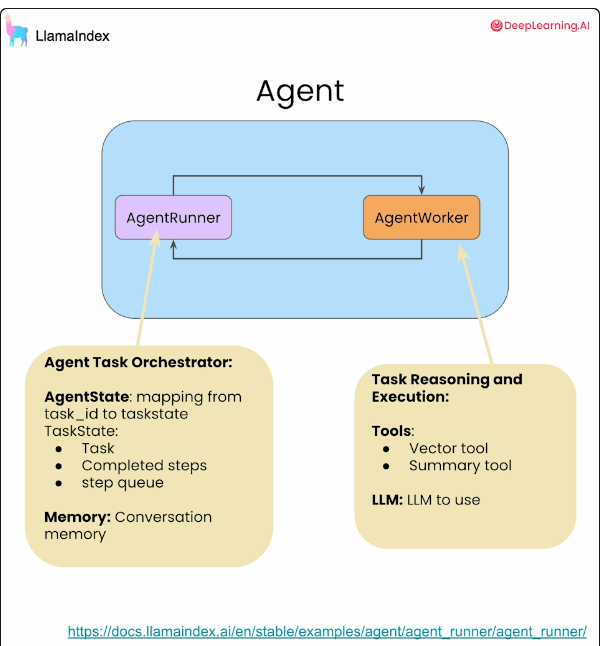

In [52]:
Image(filename="../Imgs/20240516_201241.png")

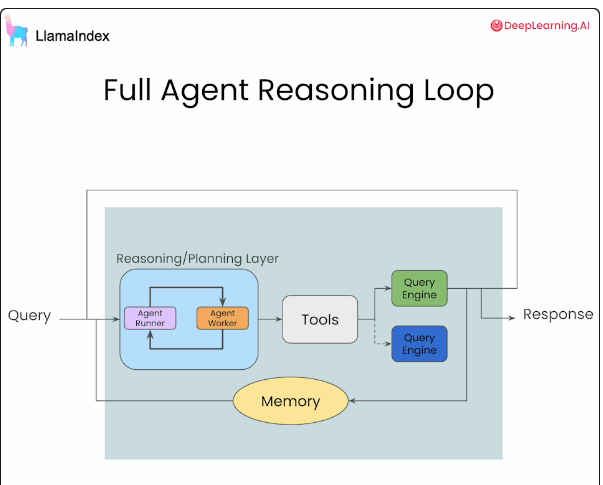

In [53]:
Image(filename="../Imgs/20240516_201558.png")

In [54]:
## Uncomment if not ran before
## vector_tool, summary_tool as defined before

#import nest_asyncio
#nest_asyncio.apply()
#from llama_index.llms.openai import OpenAI
#llm = OpenAI(model="gpt-3.5-turbo", temperature=0)

In [55]:
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

agent_worker = FunctionCallingAgentWorker.from_tools(
    [vector_tool, summary_tool], 
    llm=llm, 
    verbose=True
)
agent = AgentRunner(agent_worker)

#### Let's make a two steps query

In [56]:
response = agent.query(
    "What are the MetaGPT comparisons with ChatDev described on page 8,"
    "and how Agents communicate with other agents?"
)

Added user message to memory: What are the MetaGPT comparisons with ChatDev described on page 8,and how Agents communicate with other agents?
=== Calling Function ===
Calling function: query_engine_tool with args: {"input": "MetaGPT comparisons with ChatDev described on page 8"}
=== Function Output ===
MetaGPT outperforms ChatDev on the SoftwareDev dataset in various aspects. For example, MetaGPT achieves a higher score in executability, takes less time to generate code, uses more tokens but requires fewer tokens to generate one line of code compared to ChatDev. Additionally, MetaGPT demonstrates better code statistics and lower human revision costs than ChatDev. These comparisons highlight the advantages of MetaGPT over ChatDev in software generation tasks.
=== Calling Function ===
Calling function: query_engine_tool with args: {"input": "Agents communicate with other agents"}
=== Function Output ===
Agents communicate with other agents through structured documents and diagrams rather

In [57]:
print(response.source_nodes[0].get_content(metadata_mode="all"))

page_label: 8
file_name: metagpt.pdf
file_path: ../Data/metagpt.pdf
file_type: application/pdf
file_size: 16911937
creation_date: 2024-05-30
last_modified_date: 2024-05-30

Preprint
Figure 5: Demo softwares developed by MetaGPT.
in these two public benchmarks. Moreover, as shown in Table 1, MetaGPT outperforms ChatDev on
the challenging SoftwareDev dataset in nearly all metrics. For example, considering the executabil-
ity, MetaGPT achieves a score of 3.75, which is very close to 4 (flawless). Besides, it takes less time
(503 seconds), clearly less than ChatDev. Considering the code statistic and the cost of human revi-
sion, it also significantly outperforms ChatDev. Although MetaGPT requires more tokens (24,613
or 31,255 compared to 19,292), it needs only 126.5/124.3 tokens to generate one line of code. In
contrast, ChatDev uses 248.9 tokens. These results highlight the benefits of SOPs in collabora-
tions between multiple agents. Additionally, we demonstrate the autonomous software 

In [58]:
response = agent.chat(
    "Tell me about the evaluation datasets used."
)

Added user message to memory: Tell me about the evaluation datasets used.
=== Calling Function ===
Calling function: summary_tool with args: {"input": "evaluation datasets used in MetaGPT"}
=== Function Output ===
The evaluation datasets used in MetaGPT include HumanEval, MBPP, and a self-generated SoftwareDev dataset. The HumanEval dataset consists of 164 handwritten programming tasks, while the MBPP dataset consists of 427 Python tasks. The SoftwareDev dataset comprises 70 representative examples of software development tasks, covering various scopes such as mini-games, image processing algorithms, and data visualization. These datasets were utilized to evaluate the performance of MetaGPT in code generation tasks.
=== LLM Response ===
The evaluation datasets used in MetaGPT include HumanEval, MBPP, and a self-generated SoftwareDev dataset. The HumanEval dataset consists of 164 handwritten programming tasks, the MBPP dataset consists of 427 Python tasks, and the SoftwareDev dataset co

In [59]:
response = agent.chat("Tell me the results over one of the above datasets.")

Added user message to memory: Tell me the results over one of the above datasets.
=== Calling Function ===
Calling function: query_engine_tool with args: {"input": "Results of MetaGPT over the HumanEval dataset"}
=== Function Output ===
MetaGPT achieved pass rates of 85.9% and 87.7% over the HumanEval dataset.
=== LLM Response ===
Over the HumanEval dataset, MetaGPT achieved pass rates of 85.9% and 87.7%.


## Lower-Level: Debuggability and Control

In [60]:
agent_worker = FunctionCallingAgentWorker.from_tools(
    [vector_tool, summary_tool], 
    llm=llm, 
    verbose=True
)
agent = AgentRunner(agent_worker)

In [61]:
task = agent.create_task(
    "Tell me about the agent roles in MetaGPT, "
    "and then how they communicate with each other."
)

In [62]:
step_output = agent.run_step(task.task_id)

Added user message to memory: Tell me about the agent roles in MetaGPT, and then how they communicate with each other.
=== Calling Function ===
Calling function: summary_tool with args: {"input": "Agent roles in MetaGPT"}
=== Function Output ===
The agent roles in MetaGPT include the Product Manager, Architect, Project Manager, Engineer, and QA Engineer. The Product Manager is responsible for creating the Product Requirement Document (PRD), the Architect designs technical specifications and system architecture, the Project Manager breaks down tasks and assigns them to Engineers, the Engineer implements development tasks based on technical specifications, and the QA Engineer generates unit test code and reviews the code output for quality assurance.


In [63]:
completed_steps = agent.get_completed_steps(task.task_id)
print(f"Num completed for task {task.task_id}: {len(completed_steps)}")
print(completed_steps[0].output.sources[0].raw_output)

Num completed for task fcbc209c-8438-4d75-80ef-0912b815f985: 1
The agent roles in MetaGPT include the Product Manager, Architect, Project Manager, Engineer, and QA Engineer. The Product Manager is responsible for creating the Product Requirement Document (PRD), the Architect designs technical specifications and system architecture, the Project Manager breaks down tasks and assigns them to Engineers, the Engineer implements development tasks based on technical specifications, and the QA Engineer generates unit test code and reviews the code output for quality assurance.


In [64]:
upcoming_steps = agent.get_upcoming_steps(task.task_id)
print(f"Num upcoming steps for task {task.task_id}: {len(upcoming_steps)}")
upcoming_steps[0]

Num upcoming steps for task fcbc209c-8438-4d75-80ef-0912b815f985: 1


TaskStep(task_id='fcbc209c-8438-4d75-80ef-0912b815f985', step_id='9408c9cf-eeb1-4ea1-a84b-13a5a7352623', input=None, step_state={}, next_steps={}, prev_steps={}, is_ready=True)

### Inserting a new step in the task

In [65]:
step_output = agent.run_step(
    task.task_id, input="What about how agents share information?"
)

Added user message to memory: What about how agents share information?
=== Calling Function ===
Calling function: summary_tool with args: {"input": "How agents share information in MetaGPT"}
=== Function Output ===
Agents in MetaGPT share information through a shared message pool where they publish structured messages and can subscribe to relevant messages based on their profiles. This shared message pool allows all agents to exchange messages directly, enhancing communication efficiency. Additionally, agents utilize a subscription mechanism to extract relevant information based on their role profiles, ensuring that they receive only task-related information and avoid distractions from irrelevant details. This structured communication approach in MetaGPT helps streamline workflows and improve collaboration among the agents.


In [66]:
step_output = agent.run_step(task.task_id)
print(step_output.is_last)

=== LLM Response ===
In MetaGPT, agents share information through a shared message pool where they publish structured messages and subscribe to relevant messages based on their profiles. This structured communication approach enhances efficiency and collaboration among the agents.
True


In [67]:
response = agent.finalize_response(task.task_id)

In [68]:
print(str(response))

assistant: In MetaGPT, agents share information through a shared message pool where they publish structured messages and subscribe to relevant messages based on their profiles. This structured communication approach enhances efficiency and collaboration among the agents.


# 5th. Example - [Building a Multi-Document Agent](https://docs.llamaindex.ai/en/stable/examples/agent/multi_document_agents/)

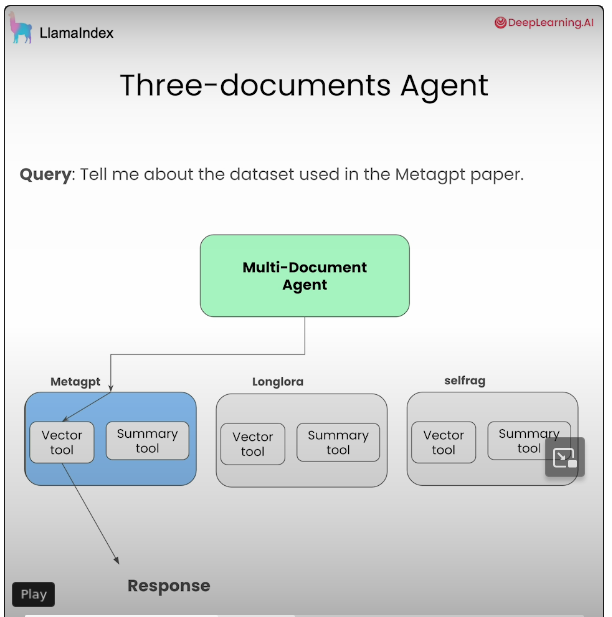

In [69]:
Image(filename="../Imgs/20240516_230659.png") 

## Setup an Multi-Document Agent over 3 papers

In [70]:
## Uncomment if not ran before
#from llama_index.llms.openai import OpenAI
#llm = OpenAI(model="gpt-3.5-turbo")
#import nest_asyncio
#nest_asyncio.apply()
#from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, SummaryIndex
#from llama_index.core.node_parser import SentenceSplitter
#from llama_index.core.tools import FunctionTool, QueryEngineTool
#from llama_index.core.vector_stores import MetadataFilters, FilterCondition
from typing import List, Optional
from pathlib import Path

In [71]:
def get_doc_tools(file_path: str, name: str,) -> str:
    """Get vector query and summary query tools from a document."""

    documents = SimpleDirectoryReader(input_files=[file_path]).load_data()
    splitter = SentenceSplitter(chunk_size=1024)
    nodes = splitter.get_nodes_from_documents(documents)
    vector_index = VectorStoreIndex(nodes)
    
    def vector_query(query: str, page_numbers: Optional[List[str]] = None) -> str:
        """Use to answer questions over a given paper.
    
        Useful if you have specific questions over the paper.
        Always leave page_numbers as None UNLESS there is a specific page you want to search for.
    
        Args:
            query (str): the string query to be embedded.
            page_numbers (Optional[List[str]]): Filter by set of pages. Leave as NONE 
                if we want to perform a vector search
                over all pages. Otherwise, filter by the set of specified pages.
        
        """
    
        page_numbers = page_numbers or []
        metadata_dicts = [{"key": "page_label", "value": p} for p in page_numbers]
        query_engine = vector_index.as_query_engine(similarity_top_k=2,
                                                    filters=MetadataFilters.from_dicts(metadata_dicts,
                                                                                       condition=FilterCondition.OR)
                                                   )
        response = query_engine.query(query)
        return response
    
    vector_query_tool = FunctionTool.from_defaults(name=f"vector_tool_{name}", fn=vector_query)
    
    summary_index = SummaryIndex(nodes)
    summary_query_engine = summary_index.as_query_engine(response_mode="tree_summarize",                                                  use_async=True,)
    summary_tool = QueryEngineTool.from_defaults(name=f"summary_tool_{name}",
                                                 query_engine=summary_query_engine,
                                                 description=(f"Useful for summarization questions related to {name}"),)

    return vector_query_tool, summary_tool

In [72]:
docs = os.listdir(DOCS_DIR)
docs = [d for d in docs]
docs.sort()
print(f"Files in {DOCS_DIR}")
for doc in docs:
    print(doc)

Files in ../Data/
1.pdf
WarrenCommissionReport.txt
axis_report.pdf
california_housing_train.csv
hdfc_report.pdf
hr.sqlite
icici_report.pdf
kafka_metamorphosis.txt
knowledge_card.pdf
loftq.pdf
longlora.pdf
lyft_2021.pdf
metagpt.pdf
metra.pdf
paul_graham_essay.txt
selfrag.pdf
swebench.pdf
uber_2021.pdf
values.pdf
vr_mcl.pdf
zipformer.pdf


In [73]:
papers = [
    "../Data/metagpt.pdf",
    "../Data/longlora.pdf",
    "../Data/selfrag.pdf",
]

In [74]:
paper_to_tools_dict = {}
for paper in papers:
    print(f"Getting tools for paper: {paper}")
    vector_tool, summary_tool = get_doc_tools(paper, Path(paper).stem)
    paper_to_tools_dict[paper] = [vector_tool, summary_tool]

Getting tools for paper: ../Data/metagpt.pdf
Getting tools for paper: ../Data/longlora.pdf
Getting tools for paper: ../Data/selfrag.pdf


In [75]:
initial_tools = [t for paper in papers for t in paper_to_tools_dict[paper]]
print(len(initial_tools))

6


In [76]:
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

agent_worker = FunctionCallingAgentWorker.from_tools(
    initial_tools, 
    llm=llm, 
    verbose=True
)
agent = AgentRunner(agent_worker)

In [77]:
response = agent.query(
    "Tell me about the evaluation dataset used in LongLoRA, "
    "and then tell me about the evaluation results"
)

Added user message to memory: Tell me about the evaluation dataset used in LongLoRA, and then tell me about the evaluation results
=== Calling Function ===
Calling function: vector_tool_longlora with args: {"query": "evaluation dataset"}
=== Function Output ===
PG19
=== Calling Function ===
Calling function: vector_tool_longlora with args: {"query": "evaluation results"}
=== Function Output ===
evaluation results indicate that the 7B model outperforms other Llama2-based long-context models like Vicuna and LongChat, as well as GPT-3.5-Turbo, when fine-tuned to a context length of 16384. The performance is comparable or even better, achieved in a relatively short time frame of about 4 hours on a single 8 ×A100 machine, processing approximately 0.3 billion tokens.
=== LLM Response ===
The evaluation dataset used in LongLoRA is not specified in the paper. However, the evaluation results indicate that the 7B model outperforms other Llama2-based long-context models like Vicuna and LongChat, 

In [78]:
response = agent.query("Give me a summary of both Self-RAG and LongLoRA")
print(str(response))

Added user message to memory: Give me a summary of both Self-RAG and LongLoRA
=== Calling Function ===
Calling function: summary_tool_selfrag with args: {"input": "Self-RAG"}
=== Function Output ===
Self-RAG is a framework designed to improve the quality and accuracy of large language models by incorporating retrieval on demand and self-reflection mechanisms. It involves training a language model to retrieve, generate, and evaluate text passages using reflection tokens. This approach allows the model to adjust its behavior during testing by utilizing reflection tokens, resulting in notable enhancements in performance, factuality, and citation precision compared to other models.
=== Calling Function ===
Calling function: summary_tool_longlora with args: {"input": "LongLoRA"}
=== Function Output ===
LongLoRA is a framework that combines trainable normalization and embedding layers to extend the context length of large language models efficiently. It introduces S2-Attn to approximate the 

## Setup an Multi-Document Agent over 10 papers

In [79]:
papers = [
    "../Data/metagpt.pdf",
    "../Data/longlora.pdf",
    "../Data/loftq.pdf",
    "../Data/swebench.pdf",
    "../Data/selfrag.pdf",
    "../Data/zipformer.pdf",
    "../Data/values.pdf",
    "../Data/knowledge_card.pdf",
    "../Data/metra.pdf",
    "../Data/vr_mcl.pdf"
]

In [80]:
paper_to_tools_dict = {}
for paper in papers:
    print(f"Getting tools for paper: {paper}")
    vector_tool, summary_tool = get_doc_tools(paper, Path(paper).stem)
    paper_to_tools_dict[paper] = [vector_tool, summary_tool]

Getting tools for paper: ../Data/metagpt.pdf
Getting tools for paper: ../Data/longlora.pdf
Getting tools for paper: ../Data/loftq.pdf
Getting tools for paper: ../Data/swebench.pdf
Getting tools for paper: ../Data/selfrag.pdf
Getting tools for paper: ../Data/zipformer.pdf
Getting tools for paper: ../Data/values.pdf
Getting tools for paper: ../Data/knowledge_card.pdf
Getting tools for paper: ../Data/metra.pdf
Getting tools for paper: ../Data/vr_mcl.pdf


## Extend the Agent with Tool Retrieval

In [81]:
all_tools = [t for paper in papers for t in paper_to_tools_dict[paper]]

### Define an "object" index and retriever over these tools

In [82]:
#from llama_index.core import VectorStoreIndex
from llama_index.core.objects import ObjectIndex

obj_index = ObjectIndex.from_objects(
    all_tools,
    index_cls=VectorStoreIndex,
)

In [83]:
obj_retriever = obj_index.as_retriever(similarity_top_k=3)

### The tools will be chosen by similarity

In [84]:
tools = obj_retriever.retrieve(
    "Tell me about the eval dataset used in MetaGPT and SWE-Bench"
)

In [85]:
for t in tools:
    print(t.metadata)

ToolMetadata(description='Useful for summarization questions related to metagpt', name='summary_tool_metagpt', fn_schema=<class 'llama_index.core.tools.types.DefaultToolFnSchema'>, return_direct=False)
ToolMetadata(description='Useful for summarization questions related to metra', name='summary_tool_metra', fn_schema=<class 'llama_index.core.tools.types.DefaultToolFnSchema'>, return_direct=False)
ToolMetadata(description='Useful for summarization questions related to swebench', name='summary_tool_swebench', fn_schema=<class 'llama_index.core.tools.types.DefaultToolFnSchema'>, return_direct=False)


In [86]:
#from llama_index.core.agent import FunctionCallingAgentWorker
#from llama_index.core.agent import AgentRunner

agent_worker = FunctionCallingAgentWorker.from_tools(
    tool_retriever=obj_retriever,
    llm=llm, 
    system_prompt=""" \
You are an agent designed to answer queries over a set of given papers.
Please always use the tools provided to answer a question. Do not rely on prior knowledge.\

""",
    verbose=True
)
agent = AgentRunner(agent_worker)

In [87]:
response = agent.query(
    "Tell me about the evaluation dataset used "
    "in MetaGPT and compare it against SWE-Bench"
)
print(str(response))

Added user message to memory: Tell me about the evaluation dataset used in MetaGPT and compare it against SWE-Bench
=== Calling Function ===
Calling function: summary_tool_metagpt with args: {"input": "evaluation dataset used in MetaGPT"}
=== Function Output ===
The evaluation dataset used in MetaGPT is the SoftwareDev dataset, which comprises 70 diverse software development tasks. These tasks encompass a broad spectrum of challenges, including creating mini-games like Snake, Brick Breaker, and Flappy Bird, developing programs for Excel data processing and CRUD management, transcribing sheet music, and crafting custom press releases. This dataset is designed to provide a comprehensive testbed for authentic development tasks within the MetaGPT framework.
=== Calling Function ===
Calling function: summary_tool_swebench with args: {"input": "evaluation dataset used in SWE-Bench"}
=== Function Output ===
The evaluation dataset used in SWE-Bench consists of task instances constructed from p

In [88]:
response = agent.query(
    "Compare and contrast the LoRA papers (LongLoRA, LoftQ). "
    "Analyze the approach in each paper first. "
)

Added user message to memory: Compare and contrast the LoRA papers (LongLoRA, LoftQ). Analyze the approach in each paper first. 
=== Calling Function ===
Calling function: summary_tool_longlora with args: {"input": "Approach in LongLoRA"}
=== Function Output ===
The approach in LongLoRA involves extending the context length of large language models efficiently by introducing shifted sparse attention (S2-Attn) during fine-tuning. This method allows for training models with significantly larger context lengths while reducing GPU memory cost and training time compared to standard full fine-tuning, with minimal accuracy compromise. The key aspect of LongLoRA is the utilization of S2-Attn to approximate the standard self-attention pattern during training, which is easy to implement and retains the original attention architecture during inference. Additionally, LongLoRA bridges the gap between LoRA and full fine-tuning by incorporating trainable normalization and embedding layers, enabling t